<a href="https://colab.research.google.com/github/neerajrapelli/AppliedML/blob/main/HumanActivityRecognition_UCI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Import necessary libraries
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn import metrics
import os

In [2]:
# Import the Google Colaboratory drive module
from google.colab import drive

# Mount the Google Drive to the Colab notebook
# This code will prompt the user to authenticate and give permission for Colab to access their Google Drive
# After successful authentication, the user's Google Drive will be mounted to the Colab notebook at the specified directory ('/content/drive')
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Define a list of sensor signal types for the input data
# These signal types correspond to the different types of body and total acceleration and gyroscopic data 
# that were recorded by the sensors in the experiment
INPUT_SIGNAL_TYPES = [
    "body_acc_x_",
    "body_acc_y_",
    "body_acc_z_",
    "body_gyro_x_",
    "body_gyro_y_",
    "body_gyro_z_",
    "total_acc_x_",
    "total_acc_y_",
    "total_acc_z_"
]

# Define a list of activity labels for the output data
# These labels correspond to the different activities that the subjects in the experiment were performing 
# while the sensor data was being recorded
LABELS = [
    "WALKING", 
    "WALKING_UPSTAIRS", 
    "WALKING_DOWNSTAIRS", 
    "SITTING", 
    "STANDING", 
    "LAYING"
] 


In [4]:
# Import the dataclass_transform module from the typing_extensions library
from typing_extensions import dataclass_transform

# Define constants for the training and test datasets and the path to the dataset directory
TRAIN_PATH = "/train"
TEST_PATH = "/test"
DATASET_PATH = "/content/drive/MyDrive/LSTM-Human-Activity-Recognition-master/UCI HAR Dataset/UCI HAR Dataset"

# Define a function for loading the input data from the dataset
# This function takes a list of file paths as input, reads in the data from each file,
# and returns a NumPy array containing the input data
def load_input_data(file_paths):
    input_data = []
    
    for path in file_paths:
        file = open(path, 'r')
        
        # Append each series of input data to the input_data list as a NumPy array
        input_data.append(
            [np.array(series, dtype=np.float32) for series in [
                row.replace('  ', ' ').strip().split(' ') for row in file
            ]]
        )
        file.close()
    
    # Convert the input_data list into a NumPy array with shape (number of samples, number of timesteps, number of input features)
    # by transposing the dimensions of the array
    return np.transpose(np.array(input_data), (1, 2, 0))

# Define the file paths for the input data in the training and test datasets
train_input_paths = [
    DATASET_PATH + TRAIN_PATH + "/Inertial Signals/" + signal + "train.txt" for signal in INPUT_SIGNAL_TYPES
]
test_input_paths = [
    DATASET_PATH + TEST_PATH + "/Inertial Signals/" + signal + "test.txt" for signal in INPUT_SIGNAL_TYPES
]

# Load the input data from the training and test datasets using the load_input_data function
X_train = load_input_data(train_input_paths)
X_test = load_input_data(test_input_paths)

# Define a function for loading the output data from the dataset
# This function takes a file path as input, reads in the data from the file,
# and returns a NumPy array containing the output data
def load_output_data(y_path):
    file = open(y_path, 'r')
    
    # Convert the output data to a NumPy array with data type np.int32
    output_data = np.array(
        [elem for elem in [
            row.replace('  ', ' ').strip().split(' ') for row in file
        ]], 
        dtype=np.int32
    )
    file.close()
    
    # Subtract 1 from each element in the output array to shift the labels to the range [0, num_classes - 1]
    return output_data - 1

# Define the file paths for the output data in the training and test datasets
train_output_path = DATASET_PATH + TRAIN_PATH + "/y_train.txt"
test_output_path = DATASET_PATH + TEST_PATH + "/y_test.txt"

# Load the output data from the training and test datasets using the load_output_data function
y_train = load_output_data(train_output_path)
y_test = load_output_data(test_output_path)


In [5]:
# Set up hyperparameters
training_data_count = len(X_train) # number of training examples
test_data_count = len(X_test) # number of testing examples
n_steps = len(X_train[0]) # number of timesteps in each sequence
n_input = len(X_train[0][0]) # number of input features
n_hidden = 32 # number of hidden units in the LSTM layer
n_classes = 6 # number of output classes
learning_rate = 0.0025 # learning rate for the optimizer
lambda_loss_amount = 0.0015 # L2 regularization coefficient
training_iters = training_data_count * 300 # number of training iterations
batch_size = 1500 # batch size for each iteration
display_iter = 30000 # frequency of displaying loss during training

# Print useful information about the dataset
print("Some useful information about the dataset:")
print("Number of training examples:", training_data_count)
print("Number of testing examples:", test_data_count)
print("Number of timesteps in each sequence:", n_steps)
print("Number of input features:", n_input)
print("Number of hidden units in the LSTM layer:", n_hidden)
print("Number of output classes:", n_classes)
print("Learning rate for the optimizer:", learning_rate)
print("L2 regularization coefficient:", lambda_loss_amount)
print("Number of training iterations:", training_iters)
print("Batch size for each iteration:", batch_size)
print("Frequency of displaying loss during training:", display_iter)
print("X shape:", X_test.shape)
print("Y shape:", y_test.shape)
print("Every X's mean:", np.mean(X_test))
print("every X's standard deviation: ", np.std(X_test))
print("As a result, the dataset has been appropriately normalized but has not yet been one-hot encoded.")


Some useful information about the dataset:
Number of training examples: 7352
Number of testing examples: 2947
Number of timesteps in each sequence: 128
Number of input features: 9
Number of hidden units in the LSTM layer: 32
Number of output classes: 6
Learning rate for the optimizer: 0.0025
L2 regularization coefficient: 0.0015
Number of training iterations: 2205600
Batch size for each iteration: 1500
Frequency of displaying loss during training: 30000
X shape: (2947, 128, 9)
Y shape: (2947, 1)
Every X's mean: 0.09913992
every X's standard deviation:  0.39567086
As a result, the dataset has been appropriately normalized but has not yet been one-hot encoded.


In [6]:
import tensorflow as tf
import numpy as np

# Define LSTM_RNN function that takes input tensor, weights, and biases and returns output tensor
def LSTM_RNN(input_tensor, weights, biases, n_input, n_hidden, n_steps):

    # Transpose input tensor to get it in the shape of [n_steps, batch_size, n_input]
    input_tensor = tf.transpose(input_tensor, [1, 0, 2])  

    # Reshape input tensor to get it in the shape of [(n_steps * batch_size), n_input]
    input_tensor = tf.reshape(input_tensor, [-1, n_input]) 

    # Apply ReLU activation to the output of hidden layer
    input_tensor = tf.nn.relu(tf.matmul(input_tensor, weights['hidden']) + biases['hidden'])

    # Split input tensor into n_steps tensors of shape [batch_size, n_hidden]
    input_tensor = tf.split(input_tensor, n_steps, 0) 

    # Define two LSTM cells and create a MultiRNNCell with the defined cells
    lstm_cell_1 = tf.compat.v1.nn.rnn_cell.BasicLSTMCell(n_hidden, forget_bias=1.0, state_is_tuple=True)
    lstm_cell_2 = tf.compat.v1.nn.rnn_cell.BasicLSTMCell(n_hidden, forget_bias=1.0, state_is_tuple=True)
    lstm_cells = tf.compat.v1.nn.rnn_cell.MultiRNNCell([lstm_cell_1, lstm_cell_2], state_is_tuple=True)

    # Apply the LSTM cells to the input tensor to get the output tensor and final state tensor
    outputs, states = tf.compat.v1.nn.static_rnn(lstm_cells, input_tensor, dtype=tf.float32)

    # Get the last output tensor from the outputs tensor
    lstm_last_output = outputs[-1]

    # Multiply the last output tensor with the weights and add biases to get the final output tensor
    return tf.matmul(lstm_last_output, weights['out']) + biases['out']

In [7]:
# Define function to extract a batch of size batch_size from the training data at a given step
def extract_batch(_train_data, step, batch_size, n_steps):

    # Create a new empty numpy array of shape [batch_size, n_steps, n_input]
    shape = list(_train_data.shape)
    shape[0] = batch_size
    batch_s = np.empty(shape)

    # Loop through each element in the batch and fill it with the corresponding element from the training data
    for i in range(batch_size):
        index = ((step-1)*batch_size + i) % len(_train_data)
        batch_s[i] = _train_data[index] 

    return batch_s


# Define function to convert the class labels to one-hot encoded vectors
def one_hot_encode(y_, n_classes):

    y_ = y_.reshape(len(y_))
    return np.eye(n_classes)[np.array(y_, dtype=np.int32)]

In [8]:
import tensorflow.compat.v1 as tf
tf.disable_eager_execution()

# Define placeholders for input and output data
x = tf.placeholder(tf.float32, [None, n_steps, n_input]) # input tensor with shape [batch_size, n_steps, n_input]
y = tf.placeholder(tf.float32, [None, n_classes]) # output tensor with shape [batch_size, n_classes]

# Define the weights and biases of the model
weights = {
    'hidden': tf.Variable(tf.random_normal([n_input, n_hidden])),
    'out': tf.Variable(tf.random_normal([n_hidden, n_classes], mean=1.0))
}
biases = {
    'hidden': tf.Variable(tf.random_normal([n_hidden])),
    'out': tf.Variable(tf.random_normal([n_classes]))
}

# Generate predictions using the LSTM_RNN function
pred = LSTM_RNN(x, weights, biases, n_input, n_hidden, n_steps)

# Define the regularization term using L2 loss
l2 = lambda_loss_amount * sum(tf.nn.l2_loss(tf_var) for tf_var in tf.trainable_variables())

# Define the cost function using softmax cross entropy with logits and the L2 regularization term
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=pred)) + l2

# Define the optimizer as Adam with the given learning rate and minimize the cost function
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

# Compute the accuracy of the model
correct_pred = tf.equal(tf.argmax(pred,1), tf.argmax(y,1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))


<ipython-input-6-22ca7a28dbc4>:20: UserWarning: `tf.nn.rnn_cell.BasicLSTMCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.LSTMCell`, and will be replaced by that in Tensorflow 2.0.
  lstm_cell_1 = tf.compat.v1.nn.rnn_cell.BasicLSTMCell(n_hidden, forget_bias=1.0, state_is_tuple=True)
<ipython-input-6-22ca7a28dbc4>:21: UserWarning: `tf.nn.rnn_cell.BasicLSTMCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.LSTMCell`, and will be replaced by that in Tensorflow 2.0.
  lstm_cell_2 = tf.compat.v1.nn.rnn_cell.BasicLSTMCell(n_hidden, forget_bias=1.0, state_is_tuple=True)
Instructions for updating:
Please use `keras.layers.RNN(cell, unroll=True)`, which is equivalent to this API
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flo

In [23]:
# Create empty lists to store the training and testing losses and accuracies
test_losses = []
test_accuracies = []
train_losses = []
train_accuracies = []

# Create an interactive session and initialize all the global variables
sess = tf.InteractiveSession(config=tf.ConfigProto(log_device_placement=True))
init = tf.global_variables_initializer()
sess.run(init)

# Set the step counter to 1 and start training the model in a loop until the maximum number of training iterations is reached.
step = 1
while step * batch_size <= training_iters:
    # Extract the current batch of training data and labels and convert the labels to one-hot encoding.
    batch_xs = extract_batch(X_train, step, batch_size, n_steps)
    batch_ys = one_hot_encode(extract_batch(y_train, step, batch_size, n_steps), n_classes)   

    # Run the optimizer and calculate the current training loss and accuracy using the current batch of data.
    _, loss, acc = sess.run(
        [optimizer, cost, accuracy],
        feed_dict={
            x: batch_xs, 
            y: batch_ys
        }
    )

    # Append the training loss and accuracy to their respective lists.
    train_losses.append(loss)
    train_accuracies.append(acc)

    # Print the training loss and accuracy every display_iter steps or if it's the first iteration or if the training is finished.
    # Then, evaluate the current model on the testing set and calculate the testing loss and accuracy. 
    # Append the testing loss and accuracy to their respective lists.
    if (step*batch_size % display_iter == 0) or (step == 1) or (step * batch_size > training_iters):
        print("Training iter #" + str(step*batch_size) + \
              ":   Batch Loss = " + "{:.6f}".format(loss) + \
              ", Accuracy = {}".format(acc))
        loss, acc = sess.run(
            [cost, accuracy], 
            feed_dict={
                x: X_test,
                y: one_hot_encode(y_test, n_classes)
            }
        )
        test_losses.append(loss)
        test_accuracies.append(acc)
        print("PERFORMANCE ON TEST SET: " + \
              "Batch Loss = {}".format(loss) + \
              ", Accuracy = {}".format(acc))

    # Increment the step counter after every iteration.
    step += 1

# Print a message to indicate that the optimization process is finished.
print("Optimization process is Finished!")

# Evaluate the final model on the testing set and calculate the final testing loss and accuracy. 
# Store the one-hot encoded predictions in one_hot_predictions.
one_hot_predictions, accuracy, final_loss = sess.run(
    [pred, accuracy, cost],
    feed_dict={
        x: X_test,
        y: one_hot_encode(y_test, n_classes)
    }
)

# Append the final testing loss and accuracy to their respective lists.
test_losses.append(final_loss)
test_accuracies.append(accuracy)

Device mapping: no known devices.


/usr/local/lib/python3.9/dist-packages/tensorflow/python/client/session.py:1769: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


Training iter #1500:   Batch Loss = 2.957837, Accuracy = 0.09600000083446503
PERFORMANCE ON TEST SET: Batch Loss = 2.562664270401001, Accuracy = 0.25958600640296936
Training iter #30000:   Batch Loss = 1.515425, Accuracy = 0.6600000262260437
PERFORMANCE ON TEST SET: Batch Loss = 1.5521774291992188, Accuracy = 0.6267390847206116
Training iter #60000:   Batch Loss = 1.179892, Accuracy = 0.7160000205039978
PERFORMANCE ON TEST SET: Batch Loss = 1.3117585182189941, Accuracy = 0.6806922554969788
Training iter #90000:   Batch Loss = 1.031331, Accuracy = 0.8133333325386047
PERFORMANCE ON TEST SET: Batch Loss = 1.1509134769439697, Accuracy = 0.7594163417816162
Training iter #120000:   Batch Loss = 0.878710, Accuracy = 0.8740000128746033
PERFORMANCE ON TEST SET: Batch Loss = 1.1255998611450195, Accuracy = 0.7940278053283691
Training iter #150000:   Batch Loss = 0.751371, Accuracy = 0.9480000138282776
PERFORMANCE ON TEST SET: Batch Loss = 1.0379717350006104, Accuracy = 0.8259246945381165
Training

In [24]:
# Print the final testing loss and accuracy.
print("Final Result: " +
    "Batch Loss = {}".format(final_loss) +
    ", Accuracy = {}".format(accuracy))


Final Result: Batch Loss = 0.689373254776001, Accuracy = 0.8866643905639648


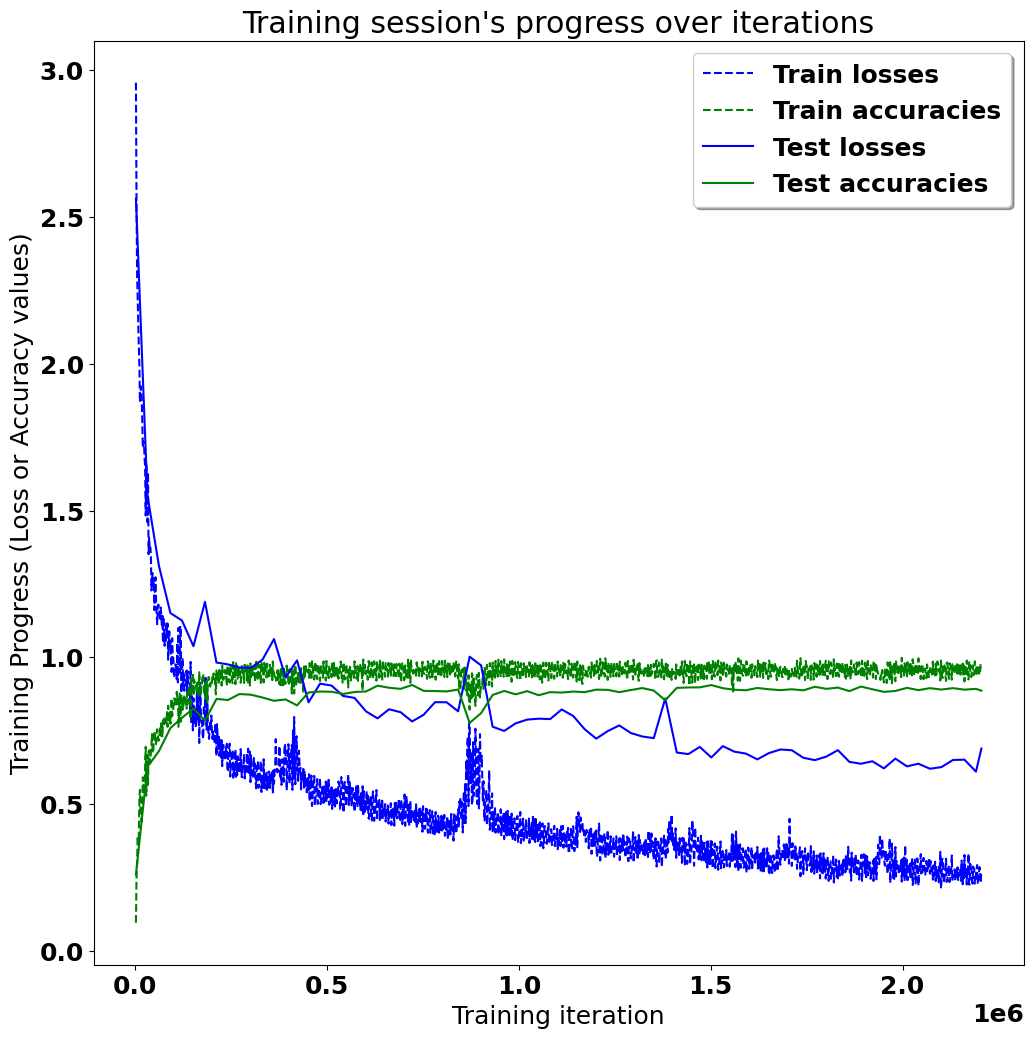

In [25]:
# Set the font family and size for the plot
import matplotlib
import matplotlib.font_manager as font_manager
matplotlib.rcParams['font.family'] = 'sans-serif'
matplotlib.rcParams['font.sans-serif'] = ['DejaVu Sans']

# Show the plot in the Jupyter notebook
%matplotlib inline

# Define the font for the plot
font = {
    'family' : 'DejaVu Sans',
    'weight' : 'bold',
    'size' : 18
}
matplotlib.rc('font', **font)

# Set the width and height of the figure
width = 12
height = 12

# Create a new plot
plt.figure(figsize=(width, height))

# Define the x-axis for the training plot
indep_train_axis = np.array(range(batch_size, (len(train_losses)+1)*batch_size, batch_size))

# Plot the training loss and accuracy
plt.plot(indep_train_axis, np.array(train_losses), "b--", label="Train losses")
plt.plot(indep_train_axis, np.array(train_accuracies), "g--", label="Train accuracies")

# Define the x-axis for the testing plot
indep_test_axis = np.append(
    np.array(range(batch_size, len(test_losses)*display_iter, display_iter)[:-1]),
    [training_iters]
)

# Plot the testing loss and accuracy
plt.plot(indep_test_axis, np.array(test_losses), "b-", label="Test losses")
plt.plot(indep_test_axis, np.array(test_accuracies), "g-", label="Test accuracies")

# Set the title and labels for the plot
plt.title("Training session's progress over iterations")
plt.legend(loc='upper right', shadow=True)
plt.ylabel('Training Progress (Loss or Accuracy values)')
plt.xlabel('Training iteration')

# Show the plot
plt.show()


In [26]:
# Set the font family for the plot
import matplotlib
matplotlib.rcParams['font.family'] = 'sans-serif'
matplotlib.rcParams['font.sans-serif'] = ['DejaVu Sans']

# Make predictions using the trained model
predictions = one_hot_predictions.argmax(1)

# Print out the testing accuracy and other evaluation metrics
print("Testing Accuracy: {}%".format(100*accuracy))
print("")
print("Precision: {}%".format(100*metrics.precision_score(y_test, predictions, average="weighted")))
print("Recall: {}%".format(100*metrics.recall_score(y_test, predictions, average="weighted")))
print("f1_score: {}%".format(100*metrics.f1_score(y_test, predictions, average="weighted")))

# Print out the confusion matrix and the normalised confusion matrix
print("")
print("Confusion Matrix:")
confusion_matrix = metrics.confusion_matrix(y_test, predictions)
print(confusion_matrix)
normalised_confusion_matrix = np.array(confusion_matrix, dtype=np.float32)/np.sum(confusion_matrix)*100
print("")
print("Matrix of confusion (normalized to % of the total test data):")
print(normalised_confusion_matrix)
print("Note that not all classes receive an equal distribution of training and testing data, ")
print("Therefore, it is expected that more than a sixth of the data is classified correctly in the final category.")

Testing Accuracy: 88.66643905639648%

Precision: 89.07043640273625%
Recall: 88.66644044791313%
f1_score: 88.71384969707695%

Confusion Matrix:
[[428  45  23   0   0   0]
 [ 22 431  16   2   0   0]
 [  3  10 407   0   0   0]
 [  1  24   0 390  76   0]
 [  1  16   0  68 447   0]
 [  0  27   0   0   0 510]]

Matrix of confusion (normalized to % of the total test data):
[[14.523244    1.5269766   0.7804547   0.          0.          0.        ]
 [ 0.7465219  14.625043    0.542925    0.06786563  0.          0.        ]
 [ 0.10179844  0.3393281  13.810656    0.          0.          0.        ]
 [ 0.03393281  0.8143875   0.         13.233797    2.578894    0.        ]
 [ 0.03393281  0.542925    0.          2.3074312  15.167968    0.        ]
 [ 0.          0.916186    0.          0.          0.         17.305735  ]]
Note that not all classes receive an equal distribution of training and testing data, 
Therefore, it is expected that more than a sixth of the data is classified correctly in the f

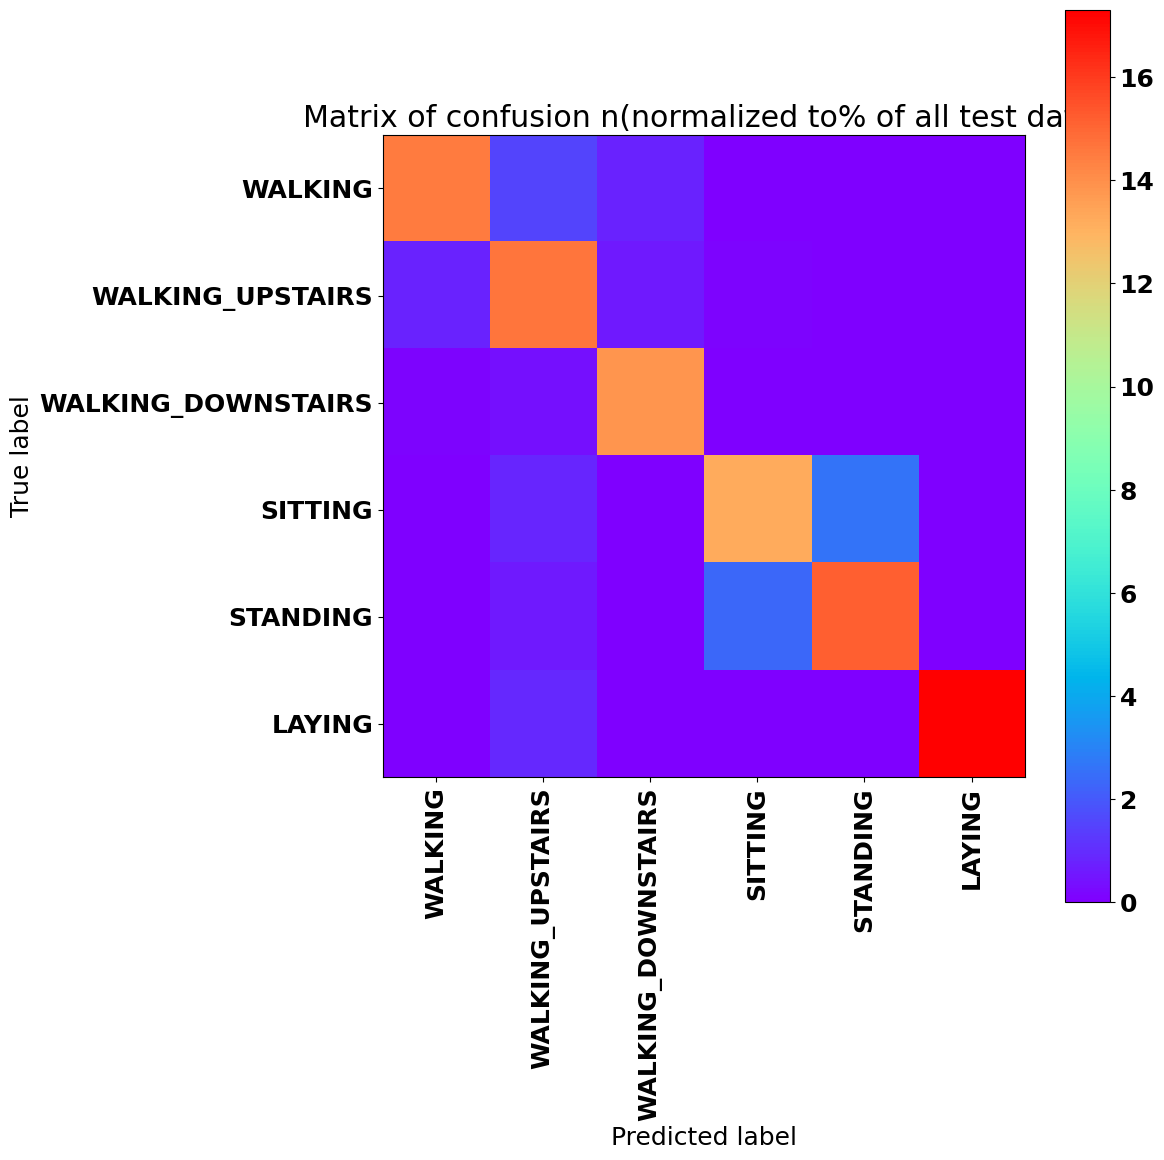

In [27]:
# Set the width and height of the figure
width = 12
height = 12

# Create a new plot and show the normalised confusion matrix
plt.figure(figsize=(width, height))
plt.imshow(
    normalised_confusion_matrix,
    interpolation='nearest',
    cmap=plt.cm.rainbow
)
plt.title("Matrix of confusion n(normalized to% of all test data)")
plt.colorbar()
tick_marks = np.arange(n_classes)
plt.xticks(tick_marks, LABELS, rotation=90)
plt.yticks(tick_marks, LABELS)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()
